# Introduction to deterministic and stochastic modelling of simple biological systems
## Dr Marc Sturrock

DiffEqBiological.jl is a domain specific language (DSL) for writing chemical
reaction networks in Julia. The generated chemical reaction network model can
then be translated into a variety of mathematical models which can be solved
using components of the broader
[DifferentialEquations.jl](http://juliadiffeq.org/) ecosystem. Biomodelling.jl is a package for simulating gene expression networks, cell growth, division and partitioning. 

In this tutorial we'll provide an introduction to using DiffEqBiological to
specify chemical reaction networks, and then to solve deterministic and stochastic models generated from them. In the second part, we will then use Biomodelling.jl to understand the concepts of intrinsic and extrinsic noise.


Let's start by using the DiffEqBiological
`@reaction_network` macro to specify a simply chemical reaction network; the
reactions associated with the central dogma of molecular biology.

We first add and import the basic packages we'll need, and use Plots.jl for making
figures:

In [1]:
#First load packages
using DifferentialEquations, DiffEqBiological, Plots, Latexify
gr()

┌ Info: Recompiling stale cache file /Users/Msturrock/.julia/compiled/v1.1/Latexify/AItXo.ji for Latexify [23fbe1c1-3f47-55db-b15f-69d7ec21a316]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

We now construct the reaction network. The basic types of arrows and predefined rate laws one can use are discussed in detail within the DiffEqBiological [Chemical Reaction Models documentation](http://docs.juliadiffeq.org/latest/models/biological.html). Here we use a mix of zero order and first order rate laws. Note, $\varnothing$ corresponds to the empty state, and is used for zeroth order production and first order degradation reactions:

In [39]:
geneexpression = @reaction_network begin
    b_1, 0 --> mRNA
    d_1, mRNA --> 0
    b_2, mRNA --> mRNA + protein
    d_2, protein --> 0
end b_1 d_1 b_2 d_2

(::reaction_network) (generic function with 2 methods)

We can use Latexify to look at the corresponding reactions and understand the generated rate laws for each reaction


In [40]:
latexify(geneexpression; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ \varnothing &<=>[b_{1}][d_{1}] mRNA}\\
\ce{ mRNA &->[b_{2}] mRNA + protein}\\
\ce{ protein &->[d_{2}] \varnothing}
\end{align}
"

We can also use Latexify to look at the corresponding ODE model for the chemical system which is created using the law of mass action

In [41]:
latexify(geneexpression)

L"\begin{align}
\frac{dmRNA}{dt} =& b_{1} - d_{1} \cdot mRNA \\
\frac{dprotein}{dt} =& b_{2} \cdot mRNA - d_{2} \cdot protein
\end{align}
"

To solve the ODEs we need to specify the values of the parameters in the model, the initial condition, and the time interval to solve the model on. To do this it helps to know the orderings of the parameters and the species. Parameters are ordered in the same order they appear after the end statement in the `@reaction_network` macro. Species are ordered in the order they first appear within the @reaction_network macro. We can see these orderings using the speciesmap and paramsmap functions:

In [42]:
speciesmap(geneexpression)

OrderedCollections.OrderedDict{Symbol,Int64} with 2 entries:
  :mRNA    => 1
  :protein => 2

In [43]:
paramsmap(geneexpression)

OrderedCollections.OrderedDict{Symbol,Int64} with 4 entries:
  :b_1 => 1
  :d_1 => 2
  :b_2 => 3
  :d_2 => 4

## Solving a deterministic version of the system: ODEs 

Knowing these orderings, we can create parameter and initial condition vectors, and setup the ODEProblem we want to solve:

In [44]:
# parameters [b_1,d_1,b_2,d_2]
p = (10.0,0.1,1.0,0.001)

# initial condition [mRNA0,protein0]
u₀ = [0.0,0.0]

# time interval to solve on
tspan = (0., 5000.0)

# create the ODEProblem we want to solve
prob = ODEProblem(geneexpression, u₀, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 5000.0)
u0: [0.0, 0.0]

At this point we are all set to solve the ODEs. We can now use any ODE solver from within the DiffEq package. We'll just use the default DifferentialEquations solver for now, and then plot the solutions:

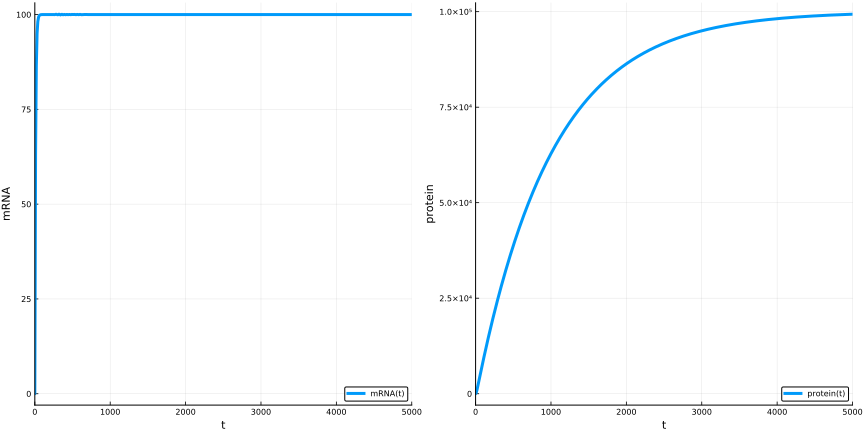

In [45]:
sol1 = solve(prob, saveat=10.)
plot(sol1,layout=(1,2),legend=:bottomright,ylabel=["mRNA" "protein"])

For more on choices of ODE solvers, see the JuliaDiffEq [documentation](http://docs.juliadiffeq.org/latest/solvers/ode_solve.html)

## Solving a stochastic version of the system: Stochastic simulation algorithm


Let's now look at a stochastic chemical kinetics model of the repressilator, modeling it with jump processes. Here we will construct a DiffEqJump JumpProblem that uses Gillespie's Direct method, and then solve it to generate one realization of the jump process:

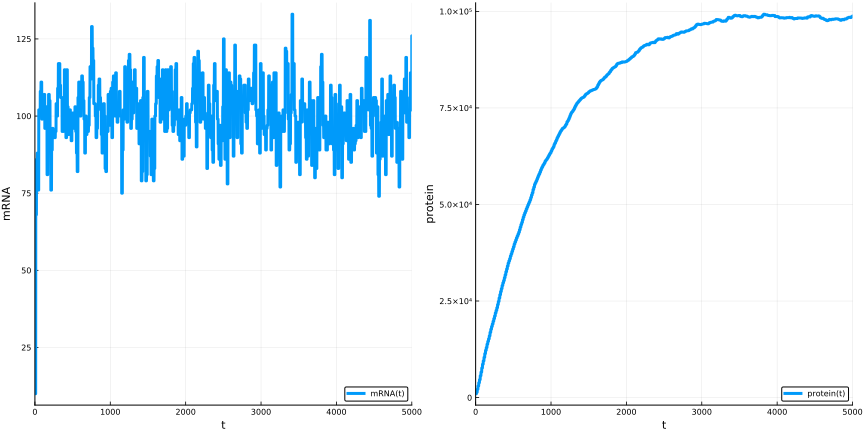

In [46]:
# first we redefine the initial condition to be integer valued
u₀ = [10,1000]

# next we create a discrete problem to encode that our species are integer valued:
dprob = DiscreteProblem(geneexpression, u₀, tspan, p)

# now we create a JumpProblem, and specify Gillespie's Direct Method as the solver:
jprob = JumpProblem(dprob, Direct(), geneexpression, save_positions=(false,false))

# now let's solve and plot the jump process:
sol2 = solve(jprob, SSAStepper(), saveat=10.)
plot(sol2,layout=(1,2),legend=:bottomright,ylabel=["mRNA" "protein"])

While SSAs generate exact realisations for stochastic chemical kinetics jump process models, a problem with the SSA is that it can be prohibitively slow, particularly when large numbers of molecules are simulated.  $\tau$-leaping methods offer a fast alternative by discretising in time the underlying time-change representation of the stochastic process. The DiffEqJump package has limited support for $\tau$-leaping methods in the form of the basic Euler's method type approximation proposed by Gillespie (Biomodelling.jl contains more tau leaping algorithms). We can simulate a $\tau$-leap approximation to the repressilator by using the  RegularJump representation of the network to construct a JumpProblem:

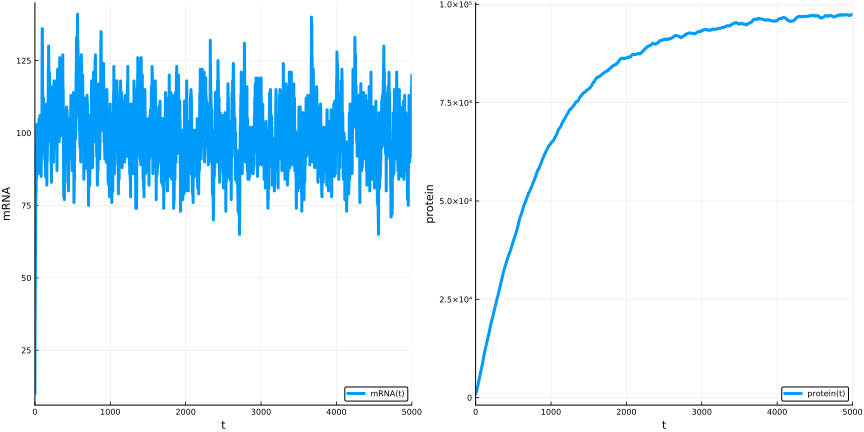

In [47]:
rjs = regularjumps(geneexpression)
lprob = JumpProblem(dprob, Direct(), rjs)
lsol = solve(lprob, SimpleTauLeaping(), dt=.1)
plot(lsol,layout=(1,2),legend=:bottomright,ylabel=["mRNA" "protein"])

By taking the mean of the stochastic solutions across 100 different simulations (representing gene expression in 100 different cells), we can see that the ordinary differential equation model gives an accurate mean-field representation of gene expression for a cell population. This is not parameter set dependent and you can try changing p defined above to whatever you like and rerunning cells.

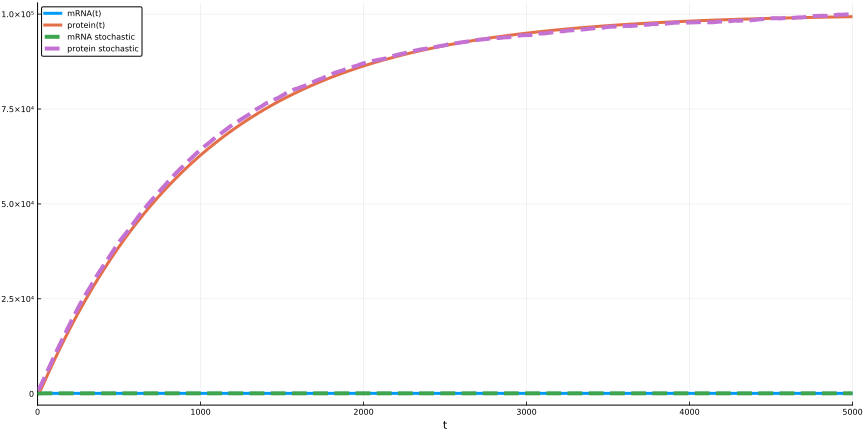

In [48]:
output = zeros(2,50001,10)
for i = 1:10
    lsol = solve(lprob, SimpleTauLeaping(), dt=.1)
    output[:,:,i] = lsol[1:2,:]
end
using Statistics
mean_stochastic_sol = mean(output,dims=3)[:,:,1]
plot(sol1)
plot!(lsol.t,mean_stochastic_sol',linestyle=:dash,linewidth=4,labels=["mRNA stochastic" "protein stochastic"])

Can we say this in general? Is the ODE model solution always consistent with the mean of the stochastic model?

## mRNA-miRNA-protein system

The paper of [Paulsson et al.](https://www.pnas.org/content/97/13/7148) provides a neat example of how even a simple system can yield different results for the stochatic and deterministic analogues. 

First we define the system, which consists of zero and first order reactions as well as a single second order reaciton. I can be interpreted as an mRNA molecule, P as a protein molecule, and S as a microRNA molecule  

In [49]:
ps = @reaction_network begin
   k, 0 --> I
   ka*S, I --> 0
   kp, I --> P
   1, P --> 0
   b, 0 --> S
   d, S --> 0
end k ka kp b d

(::reaction_network) (generic function with 2 methods)

The system can be expressed as stochastic chemical reactions in the following way

In [50]:
latexify(ps; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ \varnothing &<=>[k][ka \cdot S] I}\\
\ce{ I &->[kp] P}\\
\ce{ P &->[1] \varnothing}\\
\ce{ \varnothing &<=>[b][d] S}
\end{align}
"

Or as deterministic ODEs as the following

In [51]:
latexify(ps)

L"\begin{align}
\frac{dI}{dt} =& k - I \cdot ka \cdot S - kp \cdot I \\
\frac{dP}{dt} =& kp \cdot I - P \\
\frac{dS}{dt} =& b - d \cdot S
\end{align}
"

First we can solve the deterministic ODE system

In [52]:
# parameters [k,ka,kp,b,d]
params = (1000.0,100.0,100.0,1.0,2.0)

#initial conditions
u0 = [1.0, 1.0, 1.0]

# time interval to solve on
tspan = (0., 100.)

# create the ODEProblem we want to solve
oprob = ODEProblem(ps, u0, tspan, params)

# time points to output solution at
timestep = 1.0
ts = collect(0:timestep:maximum(tspan));

Solving the ODE system leads to

In [53]:
ode_sol  = solve(oprob, alg_hint=:stiff,saveat=ts);

Solving the corresponding stochastic system for 10 different cells, averaging and plotting alongside the ODE results leads to

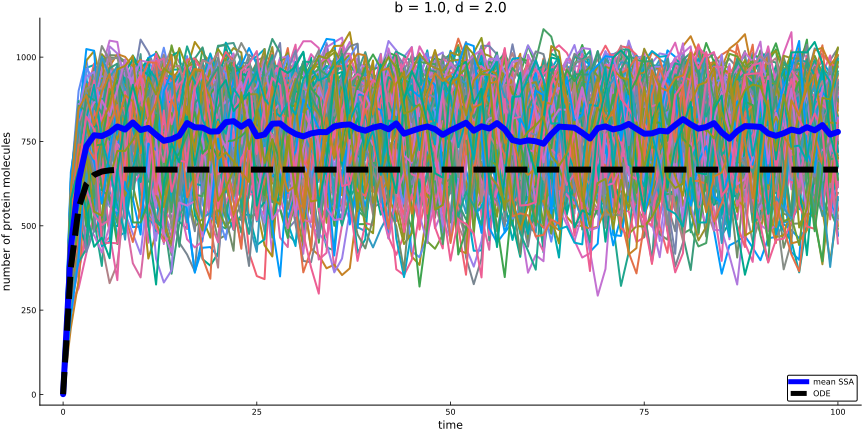

In [54]:
dprob = DiscreteProblem(ps, u0, tspan, params)
jprob = JumpProblem(dprob, Direct(), ps, save_positions = (false, false))
output = zeros(Int64,100, length(ts));
for i = 1:100
   jsol = solve(jprob, SSAStepper(), saveat = ts)
   output[i,:] = jsol[2,:]
end

plot(ode_sol.t,output',title="",labels="",xlabel="",ylabel="number of protein molecules",grid=false,linewidth=2.0)
plot!(ode_sol.t,mean(output,dims=1)',label="mean SSA",linewidth=6.0,c=:blue)
plot!(ode_sol.t,ode_sol[2,:],label="ODE",linestyle=:dash,linewidth=6.0,c=:black,xlabel="time",title="b = $(params[4]), d = $(params[5])",legend=:bottomright)

We see there is a discrepancy between the mean number of protein molecules between the stochastic system and solution of the deterministic system. However, we find that by increasing the reaction rates (while keeping the number of miRNA molecules constant), we get good agreement. Hence for some stochastic systems 

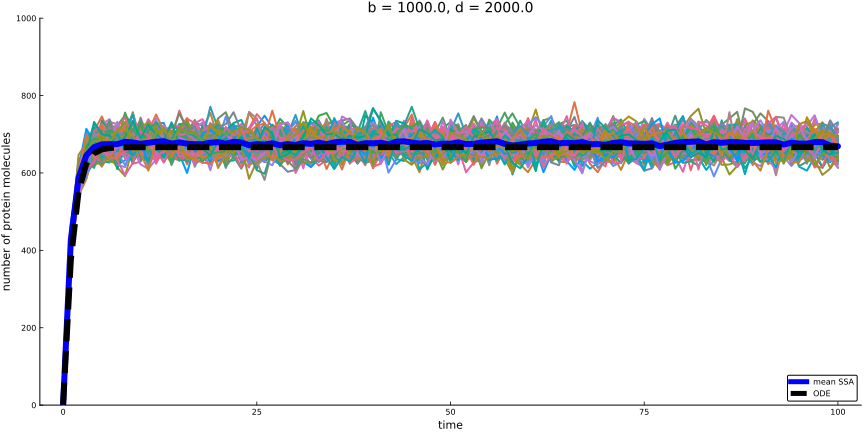

In [55]:
params = (1000.0,100.0,100.0,1000.0,2000.0)
oprob = ODEProblem(ps, u0, tspan, params)
dprob = DiscreteProblem(ps, u0, tspan, params)
jprob = JumpProblem(dprob, Direct(), ps, save_positions = (false, false))
output = zeros(Int64,100, length(ts));
for i = 1:100
   jsol = solve(jprob, SSAStepper(), saveat = ts)
   output[i,:] = jsol[2,:]
end

plot(ode_sol.t,output',title="",labels="",xlabel="",ylabel="number of protein molecules",grid=false,linewidth=2.0)
plot!(ode_sol.t,mean(output,dims=1)',label="mean SSA",linewidth=6.0,c=:blue)
plot!(ode_sol.t,ode_sol[2,:],label="ODE",linestyle=:dash,linewidth=6.0,c=:black,xlabel="time",title="b = $(params[4]), d = $(params[5])",legend=:bottomright,ylims=(0,1000))

As soon as a stochastic system contains a second order reaction (e.g. A + B --> C) it is possible that the mean of the stochastic system will deviate from the corresponding ODE system.  

## Repressilator

The repressilator is a genetic regulatory network consisting of at least one feedback loop with at least three genes, each expressing a protein that represses the next gene in the loop. In biological research, repressilators have been used to build cellular models and understand cell function. There are both artificial and naturally-occurring repressilators. Recently, the naturally-occurring repressilator clock gene circuit in Arabidopsis thaliana (A. thaliana) and mammalian systems have been studied. The repressilator can be defined as

In [56]:
repressilator = @reaction_network begin
    hillr(P₃,α,K,n), ∅ --> m₁
    hillr(P₁,α,K,n), ∅ --> m₂
    hillr(P₂,α,K,n), ∅ --> m₃
    (δ,γ), m₁ ↔ ∅
    (δ,γ), m₂ ↔ ∅
    (δ,γ), m₃ ↔ ∅
    β, m₁ --> m₁ + P₁
    β, m₂ --> m₂ + P₂
    β, m₃ --> m₃ + P₃
    μ, P₁ --> ∅
    μ, P₂ --> ∅
    μ, P₃ --> ∅
end α K n δ γ β μ;

Again we can use Latexify to look at the corresponding reactions and understand the generated rate laws for each reaction

In [57]:
latexify(repressilator; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_3^{n}}] m_{1}}\\
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_1^{n}}] m_{2}}\\
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_2^{n}}] m_{3}}\\
\ce{ m_{1} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{2} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{3} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{1} &->[\beta] m_{1} + P_{1}}\\
\ce{ m_{2} &->[\beta] m_{2} + P_{2}}\\
\ce{ m_{3} &->[\beta] m_{3} + P_{3}}\\
\ce{ P_{1} &->[\mu] \varnothing}\\
\ce{ P_{2} &->[\mu] \varnothing}\\
\ce{ P_{3} &->[\mu] \varnothing}
\end{align}
"

We can also use Latexify to look at the corresponding ODE model for the chemical system

In [22]:
latexify(repressilator)

L"\begin{align}
\frac{dm_1}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_3^{n}} - \delta \cdot m_1 + \gamma \\
\frac{dm_2}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_1^{n}} - \delta \cdot m_2 + \gamma \\
\frac{dm_3}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_2^{n}} - \delta \cdot m_3 + \gamma \\
\frac{dP_1}{dt} =& \beta \cdot m_1 - \mu \cdot P_1 \\
\frac{dP_2}{dt} =& \beta \cdot m_2 - \mu \cdot P_2 \\
\frac{dP_3}{dt} =& \beta \cdot m_3 - \mu \cdot P_3
\end{align}
"

First we can solve the deterministic ODE system

In [58]:
# parameters [α,K,n,δ,γ,β,μ]
p = (.5, 40, 2, log(2)/120, 5e-3, 20*log(2)/120, log(2)/60)

# initial condition [m₁,m₂,m₃,P₁,P₂,P₃]
u₀ = [0.,0.,0.,20.,0.,0.]

# time interval to solve on
tspan = (0., 10000.)
timestep = 1.0
ts = collect(0:timestep:maximum(tspan));

# create the ODEProblem we want to solve
oprob = ODEProblem(repressilator, u₀, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: [0.0, 0.0, 0.0, 20.0, 0.0, 0.0]

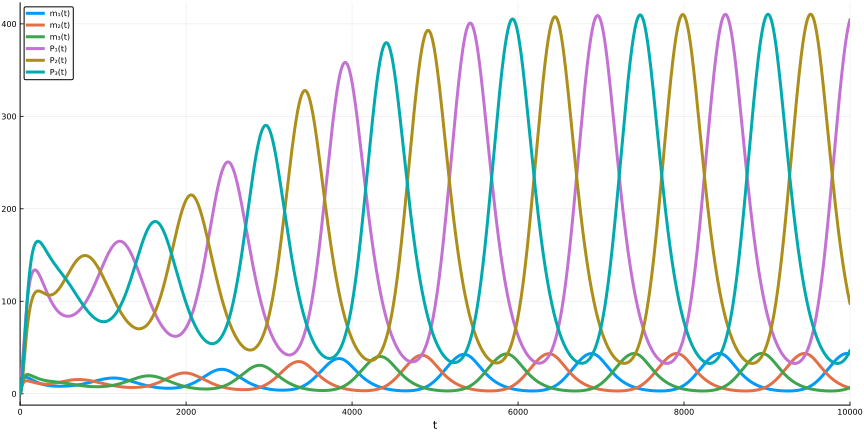

In [59]:
sol = solve(oprob, saveat=ts)
plot(sol)

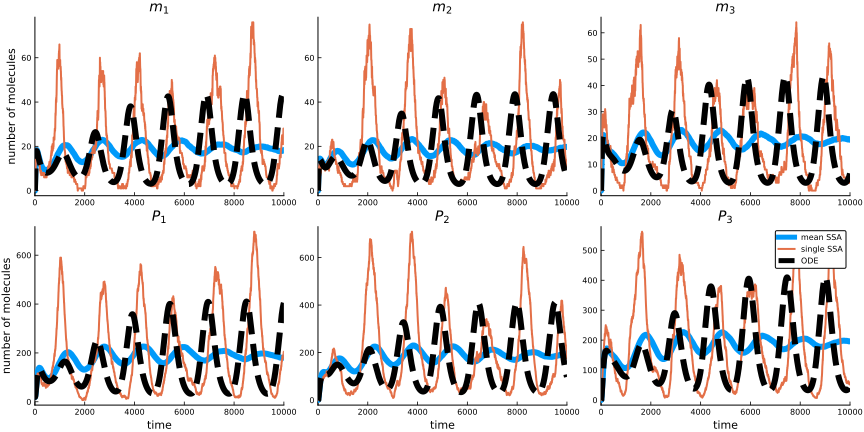

In [60]:
# solve JumpProblem using Gillespie’s Direct Method
u0 =  [0,0,0,20,0,0] # change to int type for stochastic system..
maxcell = 1000 #number of cells to simulate for
dprob = DiscreteProblem(repressilator, u0, tspan, p)
jprob = JumpProblem(dprob, Direct(), repressilator, save_positions = (false, false))
output = zeros(Int64,maxcell, length(ts),6);
for i = 1:maxcell
   jsol = solve(jprob, SSAStepper(), saveat = ts)
    for j = 1:6
       output[i,:,j] = jsol[j,:]
    end
end

using LaTeXStrings, Statistics
gr(size=(1200,600))
plot(sol.t,mean(output,dims=1)[1,:,:],title="",label=["" "" "" "" "" "mean SSA"],xlabel="",ylabel=["number of molecules" "" "" "number of molecules" "" ""],grid=false,linewidth=6.0,layout=(2,3))
plot!(sol.t,output[1,:,:],title="",label=["" "" "" "" "" "single SSA"],grid=false,linewidth=2.0,layout=(2,3))
plot!(sol,label=["" "" "" "" "" "ODE"],linestyle=:dash,linewidth=6.0,c=:black,legend=:topright,xlabel=["" "" "" "time" "time" "time"],title=[L"$m_1$" L"$m_2$" L"$m_3$" L"$P_1$" L"$P_2$" L"$P_3$"],layout=(2,3),grid=false)

Here we see qualitative (but not quantitative) agreement between the deterministic ODE solution and a single trajectory of the stochastic system. However, the mean of several stochastic simulations differs both qualitatively and quantitatively from the ODE solutions. 